In [1]:
import tensorflow as tf
import numpy as np
import copy
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
y_train_cls = copy.copy(y_train).astype(np.int32) 
y_test_cls = copy.copy(y_test).astype(np.int32)
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]
print(y_train_cls[0], y_train[0])

5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [2]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [3]:
lr = 1e-3
epoch = 100
batch_size = 150

In [4]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

In [5]:
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, 10])
y_cls = tf.placeholder(tf.int32, [None])

In [6]:
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
from tensorflow.contrib.layers import fully_connected
logits = fully_connected(states, n_outputs, activation_fn=None)
entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
loss = tf.reduce_mean(entropy)

Instructions for updating:
Please use `layer.__call__` method instead.


In [8]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(loss)

In [9]:
y_pred_cls = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 
correct_bool = tf.equal(y_pred_cls, y_cls, name='correct_bool') 
accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32), name='accuracy')

In [10]:
init = tf.global_variables_initializer()

In [11]:
with tf.Session() as sess:
    
    init.run()
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epoch):
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        x_epoch = x_train[idx]
        y_epoch = y_train[idx]
        y_cls_epoch = y_train_cls[idx]
        for k in range(x_train.shape[0]//batch_size):
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            y_batch = y_epoch[k*batch_size:(k+1)*batch_size]
            y_cls_batch = y_cls_epoch[k*batch_size:(k+1)*batch_size]
            feed_dict = {x:x_batch, y:y_batch, y_cls:y_cls_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)
    
    feed_dict = {x:x_test, y:y_test, y_cls:y_test_cls}
    accuracy_run, y_test_cls_pred = sess.run([accuracy, y_pred_cls], feed_dict=feed_dict)

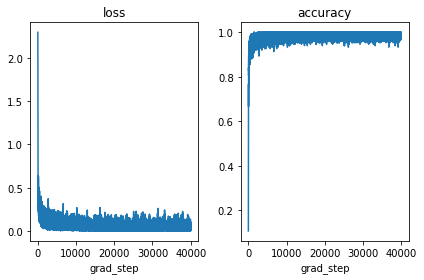

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [13]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.9756


In [14]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
print(cm)

[[ 969    0    0    0    3    1    2    1    2    2]
 [   0 1124    2    3    2    1    1    0    2    0]
 [   1    1 1015    4    5    0    0    2    3    1]
 [   1    0    5  987    0    7    0    5    0    5]
 [   0    1    1    0  969    0    5    1    1    4]
 [   1    0    0   19    1  862    4    1    2    2]
 [   5    1    2    0    7   11  929    0    3    0]
 [   1    4   15    1    6    0    0  992    1    8]
 [   4    0    2    2    6    6    3    2  945    4]
 [   0    1    1    3   27    1    1    5    6  964]]


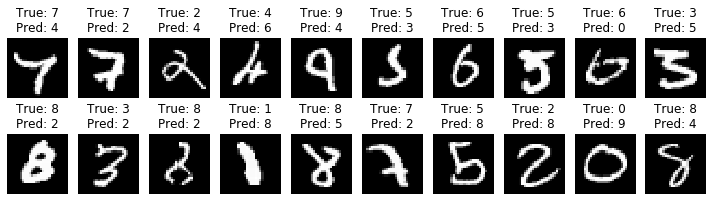

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 10, figsize=(10,3))
idx = 0
for ax in axes.reshape((-1,)):
    while True:
        if y_test_cls[idx]==y_test_cls_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap=plt.cm.gray)
            ax.set_title('True: {}\nPred: {}'.format(y_test_cls[idx], y_test_cls_pred[idx]))
            ax.axis('off')
            idx += 1
            break
plt.tight_layout()
plt.show()